### AWS Braket, Pennylane with Pulse Level Access: Rydberg Chain

In [2]:
import numpy as np
import pennylane as qml
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

wires = range(9)

# dev = qml.device('braket.local.ahs', wires=wires)
dev = qml.device('default.qubit.jax', wires=wires)

I0000 00:00:1698047833.921036       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


#### Linear chain of Rydberg atoms

Text(0, 0.5, 'y (μm)')

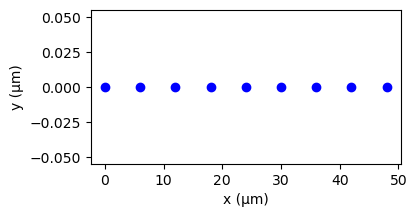

In [3]:
coordinates = [(i*6, 0) for i in range(len(wires))]

fix, ax = plt.subplots(figsize=(4, 2))
ax.plot([i*6 for i in range(len(wires))], [0 for i in range(len(wires))], 'o', color='blue')
ax.set_xlabel('x (μm)')
ax.set_ylabel('y (μm)')

#### Run on PennyLane Simulator

In [4]:
max_time = 4. # μ sec
max_amplitute = 2.4 

H_interaction = qml.pulse.rydberg_interaction(
    coordinates,
    wires=wires,
)

H_drive = qml.pulse.rydberg_drive(
    amplitude=qml.pulse.pwc(max_time),
    phase=0,
    detuning=qml.pulse.pwc(max_time),
    wires=wires,
)

@qml.qnode(dev, interface='jax')
def circuit(params, t):
    qml.evolve(H_interaction + H_drive)(params, t, return_intermediate=True)
    return [qml.expval(qml.PauliZ(i)) for i in range(len(wires))]

detuning_slope = np.arange(-8., 8.25, 0.25)
amp_slope = np.concatenate([
    np.linspace(0., max_amplitute, 50),
    max_amplitute*np.ones(200),
    np.linspace(max_amplitute, 0, 50)
])
params=[amp_slope, detuning_slope]

times = np.linspace(0.0, 4, 9)[:-1]

out = circuit(params, times)
time_vs_results = 1 - np.array(out)

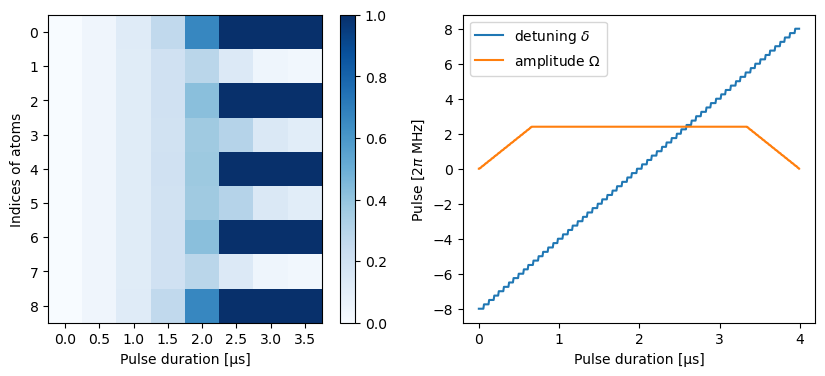

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

ax = axs[0]
data = ax.imshow(time_vs_results, cmap='Blues', vmin=0, vmax=1)   
ax.set_xticks(np.arange(len(times)), labels=times)
plt.colorbar(data)
ax.set_xlabel('Pulse duration [μs]')
ax.set_ylabel('Indices of atoms')

ax = axs[1]
plot_times = np.linspace(0.0, max_time, 500)
plot_detuning = [qml.pulse.pwc(max_time)(detuning_slope, t) for t in plot_times[:-1]]
plot_amp = [qml.pulse.pwc(max_time)(amp_slope, t) for t in plot_times[:-1]]
ax.plot(plot_times[:-1], plot_detuning, label='detuning $\\delta$')
ax.plot(plot_times[:-1], plot_amp, label='amplitude $\\Omega$')
ax.set_xlabel('Pulse duration [μs]')
ax.set_ylabel('Pulse [$2\pi$ MHz]')
ax.legend()
plt.show()

#### Run on Local Simulator

Text(0, 0.5, 'Average Rydberg density')

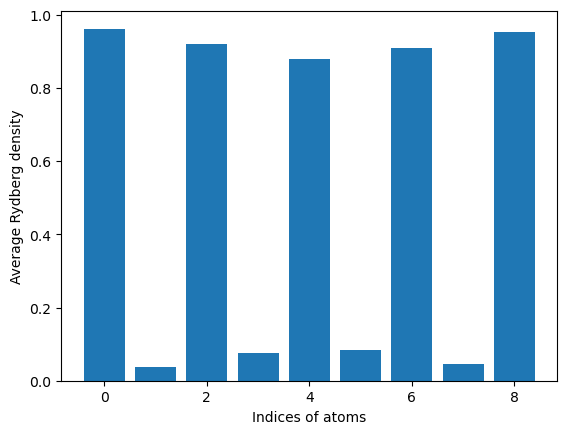

In [6]:
rydberg_simulator = qml.device('braket.local.ahs', wires=wires)

@qml.qnode(rydberg_simulator, interface='jax')
def circuit_hardware(params):
    qml.evolve(H_interaction + H_drive)(params, t=(0., max_time))
    return qml.sample()

results = circuit_hardware(params)

average_density = np.nanmean(results, axis=0) # Sometimes shots give nan values
plt.bar(range(len(average_density)), average_density)
plt.xlabel('Indices of atoms')
plt.ylabel('Average Rydberg density')